<a href="https://colab.research.google.com/github/Sahar-Zi/Medical-Speech/blob/main/Medical_Symptom_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Symptoms Audio Classification**

This data contains thousands of audio recordings for common medical symptoms like "knee pain" or "headache", totaling more than 8 hours of aggregated recording time. Each record was created by individual human contributors based on a given symptom.

These audio snippets can be used to train conversational agents in the medical field.

This dataset was created via a multi-job workflow. The first involved contributors writing text phrases to describe symptoms given. For example, for "headache", a contributor might write "I need help with my migraines". Subsequent jobs captured audio recordings for accepted text strings.

Note that some of the labels are incorrect and some of the audio files have poor quality.

I would recommend cleaning the dataset before training any machine learning models.

This dataset contains both the audio recordings and corresponding transcriptions.

Files:

patient_symptom_audio_test.zip | 2.3 GB

patient_symptom_audio_train.zip | 160.2 MB

patient_symptom_audio_validate.zip | 137.7

recordings-overview.csv | 1.7 MB

# **Table of Contents**

---

#### 1. [Libraries Imports](#SectionImports)

#### 2. [Section A (Data Exploration and Pre-processing)](#SectionA)

# **Libraries Imports**
<a class="anchor" id="SectionImports"></a>

In [48]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

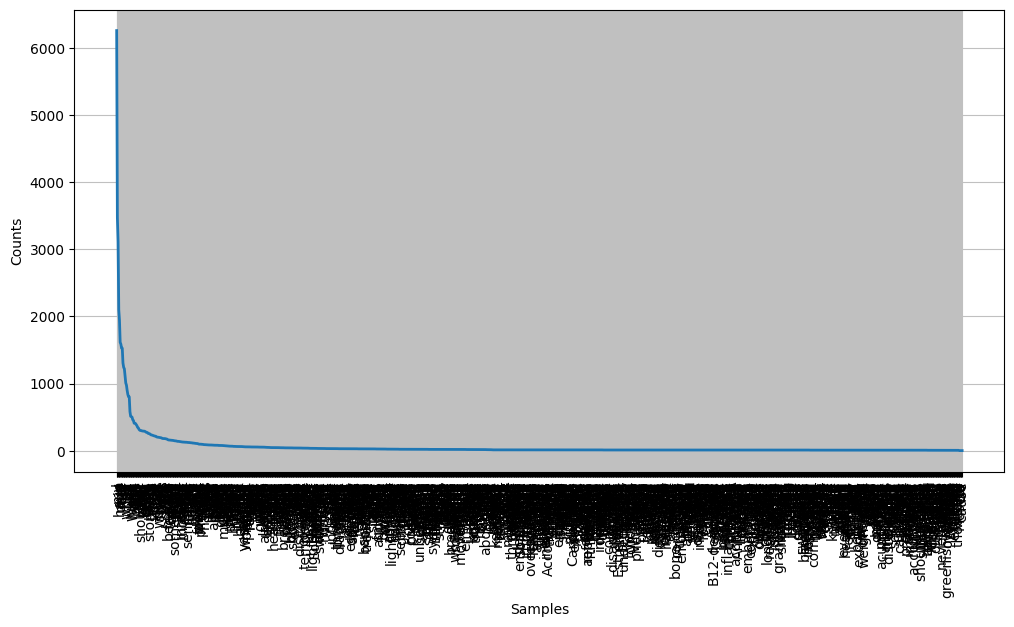

<Axes: xlabel='Samples', ylabel='Counts'>

In [58]:
phrases = ' '.join(text_dat['phrase'].tolist())
tokens = nltk.word_tokenize(phrases)
fdist = FreqDist(tokens)
plt.figure(figsize=(12, 6))
fdist.plot()

In [14]:
dat=pd.read_csv("overview-of-recordings.csv")
text_dat = dat[['prompt','audio_clipping','audio_clipping:confidence','background_noise_audible','background_noise_audible:confidence','overall_quality_of_the_audio','phrase']]
dat.head()

,prompt,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,phrase
0,Emotional pain,no_clipping,1.0000,light_noise,1.0000,3.33,When I remember her I feel down
1,Hair falling out,light_clipping,0.6803,no_noise,0.6803,3.33,When I carry heavy things I feel like breaking...
2,Heart hurts,no_clipping,1.0000,no_noise,0.6655,3.33,there is too much pain when i move my arm
3,Infected wound,no_clipping,1.0000,light_noise,1.0000,3.33,My son had his lip pierced and it is swollen a...
4,Infected wound,no_clipping,1.0000,no_noise,1.0000,4.67,My muscles in my lower back are aching
...,...,...,...,...,...,...,...
6656,Stomach ache,no_clipping,1.0000,no_noise,0.6076,3.80,I feel a burning sensation in my guts about 2 ...
6657,Open wound,no_clipping,1.0000,no_noise,0.7829,3.80,I have a split on my thumb that will not heal.
6658,Joint pain,no_clipping,1.0000,no_noise,0.6061,3.80,I feel a lot of pain in the joints.
6659,Heart hurts,no_clipping,1.0000,no_noise,0.8215,3.80,The area around my heart doesn't feel good.


I will dive in the data to understand the structure of it better:

In [3]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   audio_clipping                       6661 non-null   object 
 1   audio_clipping:confidence            6661 non-null   float64
 2   background_noise_audible             6661 non-null   object 
 3   background_noise_audible:confidence  6661 non-null   float64
 4   overall_quality_of_the_audio         6661 non-null   float64
 5   quiet_speaker                        6661 non-null   object 
 6   quiet_speaker:confidence             6661 non-null   float64
 7   speaker_id                           6661 non-null   int64  
 8   file_download                        6661 non-null   object 
 9   file_name                            6661 non-null   object 
 10  phrase                               6661 non-null   object 
 11  prompt                        

I will make changes in order to do EDA more accuratly, and the changes are:

* Change all the categorical columns to `category`

In [4]:
dat['audio_clipping'] = dat['audio_clipping'].astype('category')
dat['background_noise_audible'] = dat['background_noise_audible'].astype('category')
dat['quiet_speaker'] = dat['quiet_speaker'].astype('category')
dat['speaker_id'] = dat['speaker_id'].astype('category')
dat['prompt'] = dat['prompt'].astype('category')
dat['writer_id'] = dat['writer_id'].astype('category')

# **Section A (Data Exploration and Pre-processing)**
<a class="anchor" id="SectionA"></a>

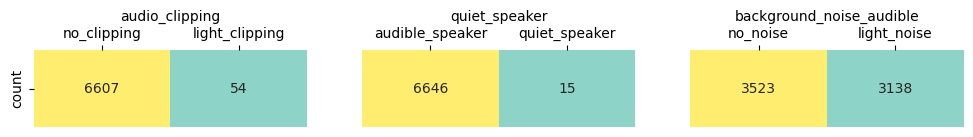

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 1))

sns.heatmap(dat['audio_clipping'].value_counts().to_frame().T, ax=axes[0], annot=True, fmt="d",cmap="Set3", cbar=False)
sns.heatmap(dat['quiet_speaker'].value_counts().to_frame().T, ax=axes[1], annot=True, fmt="d",cmap="Set3", cbar=False, yticklabels=False)
sns.heatmap(dat['background_noise_audible'].value_counts().to_frame().T, ax=axes[2], annot=True, fmt="d",cmap="Set3", cbar=False, yticklabels=False)
axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()
axes[2].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')
axes[1].xaxis.set_label_position('top')
axes[2].xaxis.set_label_position('top')
plt.show()

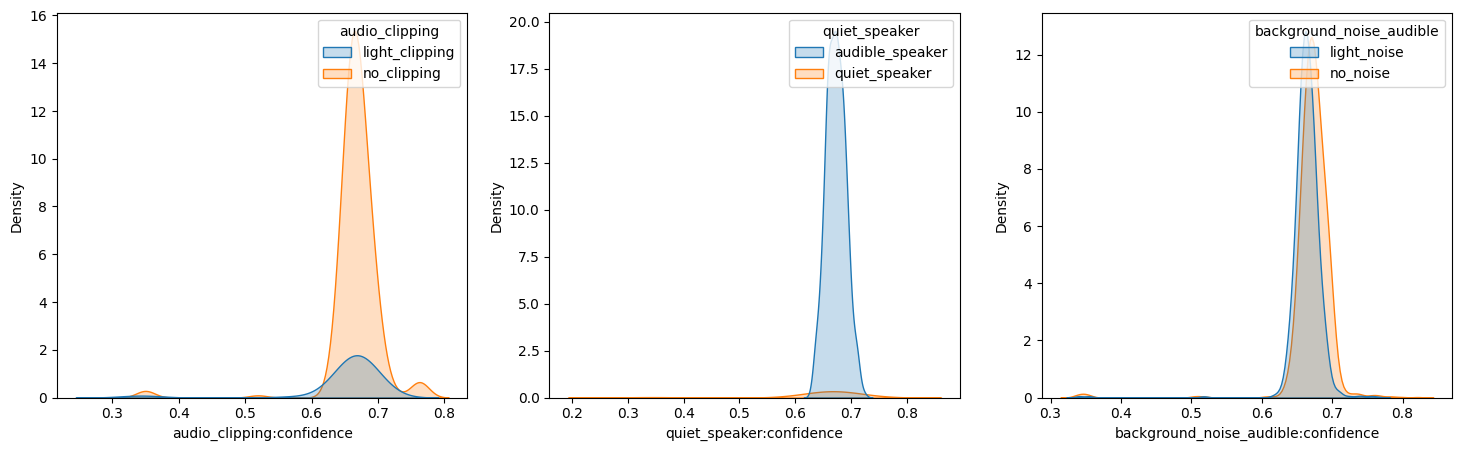

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.kdeplot(data=dat[dat['audio_clipping:confidence'] < 1], ax=axes[0], x="audio_clipping:confidence", hue="audio_clipping", fill=True)
sns.kdeplot(data=dat[dat['quiet_speaker:confidence'] < 1], ax=axes[1], x="quiet_speaker:confidence", hue="quiet_speaker", fill=True)
sns.kdeplot(data=dat[dat['background_noise_audible:confidence'] < 1], ax=axes[2], x="background_noise_audible:confidence", hue="background_noise_audible", fill=True)
plt.show()

In [ ]:
dat['overall_quality_of_the_audio'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
overall_quality_of_the_audio,6661.0,3.678268,0.378536,3.0,3.33,3.67,4.0,5.0


(0.0, 5.0)

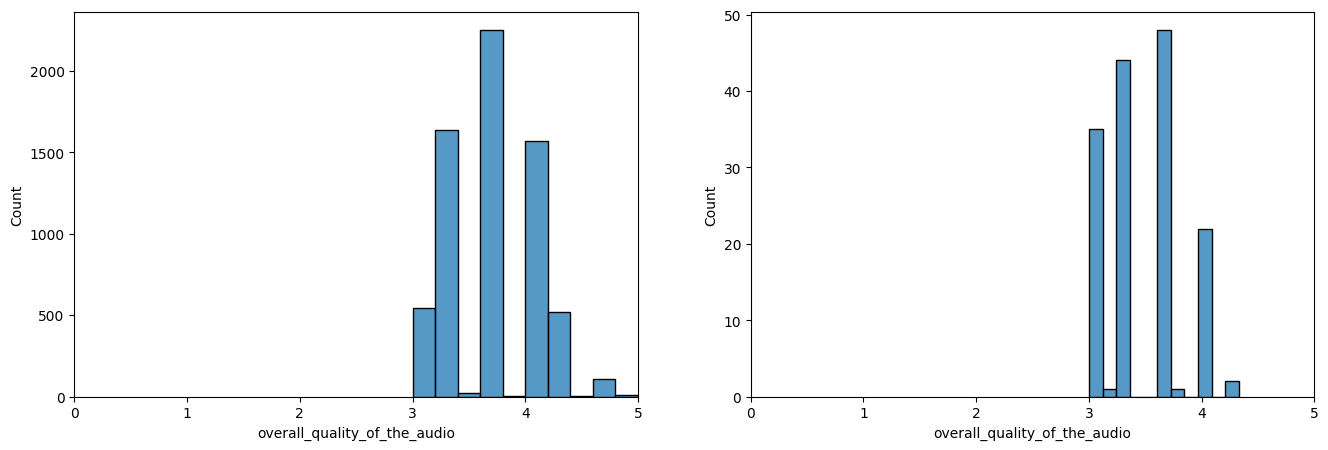

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(data=dat, x="overall_quality_of_the_audio", ax=axes[0], fill=True, bins=10)
sns.histplot(data=dat[(dat['audio_clipping:confidence']<1) & (dat['background_noise_audible:confidence']<1)], x="overall_quality_of_the_audio", ax=axes[1], fill=True)
axes[0].set_xlim(0, 5)
axes[1].set_xlim(0, 5)

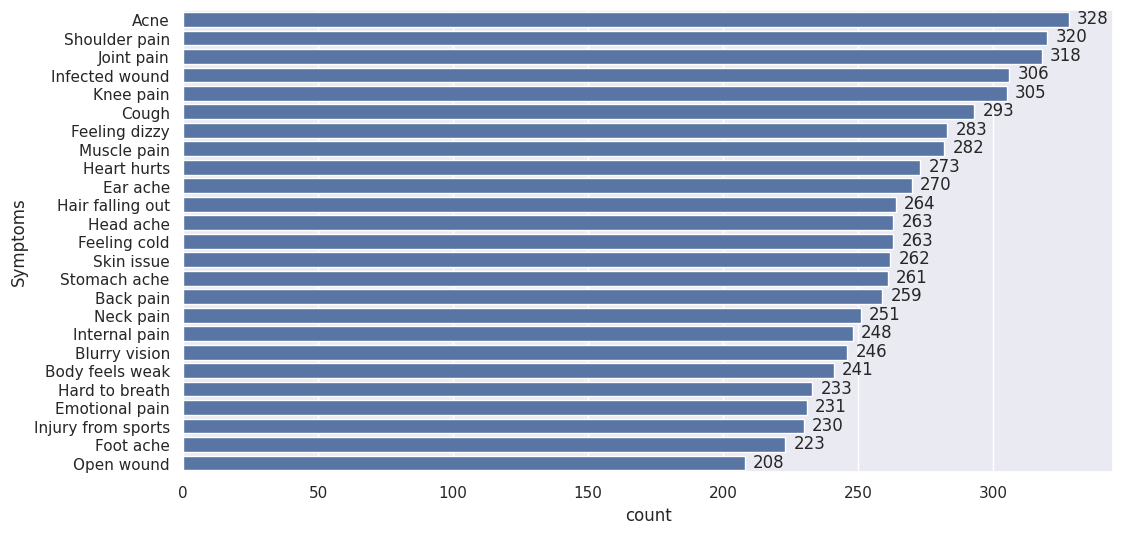

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="prompt", data=dat, order=dat['prompt'].value_counts().index)
plt.ylabel("Symptoms")
for p in ax.patches:
  ax.annotate(int(p.get_width()), (p.get_width()+3, p.get_y()+0.6))
plt.show()

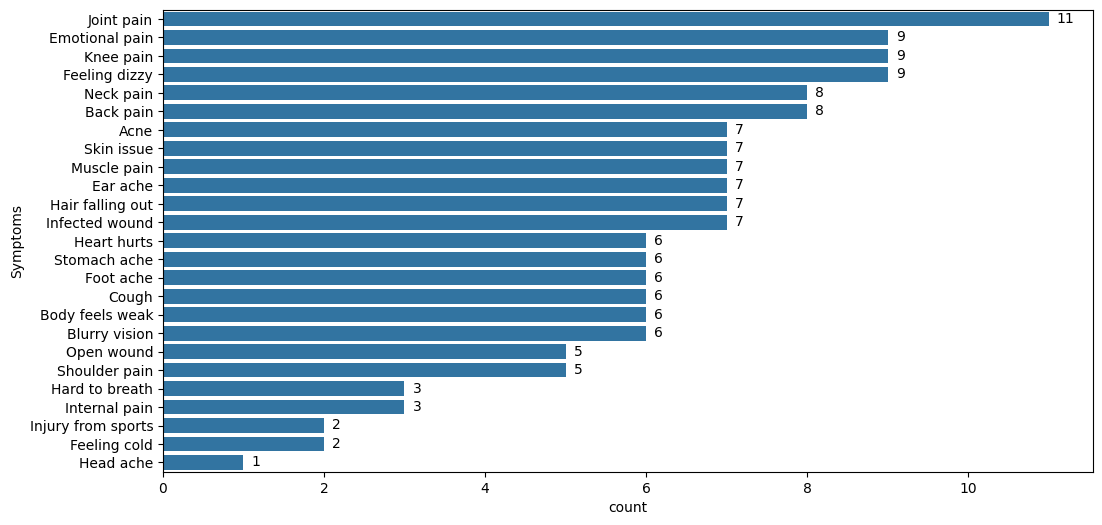

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(y="prompt", data=dat[(dat['audio_clipping:confidence']<1) & (dat['background_noise_audible:confidence']<1)], order=dat[(dat['audio_clipping:confidence']<1) & (dat['background_noise_audible:confidence']<1)]['prompt'].value_counts().index)
plt.ylabel("Symptoms")
for p in ax.patches:
  ax.annotate(int(p.get_width()), (p.get_width()+0.1, p.get_y()+0.6))
plt.show()